# Import Data From MedDRA

In [1]:
# read data from data/meddra.tsv
import pandas as pd

side_effects_path = 'data/meddra.tsv'
columns = ['UMLS_concept_id', 'MedDRA_concept_type', 'MedRA_id', 'Side_effect_name']

df = pd.read_csv(side_effects_path, sep='\t', header=None)
df.columns = columns
df.head()

,UMLS_concept_id,MedDRA_concept_type,MedRA_id,Side_effect_name
0,C0000727,LT,10000647,Acute abdomen
1,C0000727,PT,10000647,Acute abdomen
2,C0000727,LT,10042784,Syndrome abdominal acute
3,C0000727,LT,10000096,Abdominal syndrome acute
4,C0000729,LT,10000057,Abdominal cramps


In [2]:
side_effects = df['Side_effect_name'].unique()
side_effects = [str(side_effect) for side_effect in side_effects]
print('Number of unique side effects:', len(side_effects))
print('Example side effects:', side_effects[:10])

Number of unique side effects: 75604
Example side effects: ['Acute abdomen', 'Syndrome abdominal acute', 'Abdominal syndrome acute', 'Abdominal cramps', 'Abdominal cramp', 'Cramp abdominal', 'Abdominal crampy pains', 'Griping abdominal', 'Griping abdomen', 'Distended abdomen']


In [3]:
# save side_effects to a file
side_effects_path = 'data/side_effects.txt'

with open(side_effects_path, 'w') as f:
    for side_effect in side_effects:
        f.write(side_effect + '\n')

# Generate Embeddings

In [4]:
from FlagEmbedding import BGEM3FlagModel

MODEL = BGEM3FlagModel("BAAI/bge-m3", use_fp16=True)

def genEmbs(texts: list):
    embs = MODEL.encode(
        texts, return_dense=True, return_sparse=True, return_colbert_vecs=False)
    return embs['dense_vecs'], embs['lexical_weights']

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


Fetching 30 files:   0%|          | 0/30 [00:00<?, ?it/s]

In [5]:
limit = 75604

In [6]:
# dense, sparse = genEmbs(side_effects[:limit])
# print(dense.shape)

# Save the Embeddings in the Numpy Array as Pickle

In [7]:
# save as .pkl
# import pickle

# with open('vector_data/side_effects.pkl', 'wb') as f:
#     pickle.dump(dense, f)

In [8]:
import pickle

with open('vector_data/side_effects.pkl', 'rb') as f:
    dense = pickle.load(f)

# Visualization and Clustering

t-SNE part done!


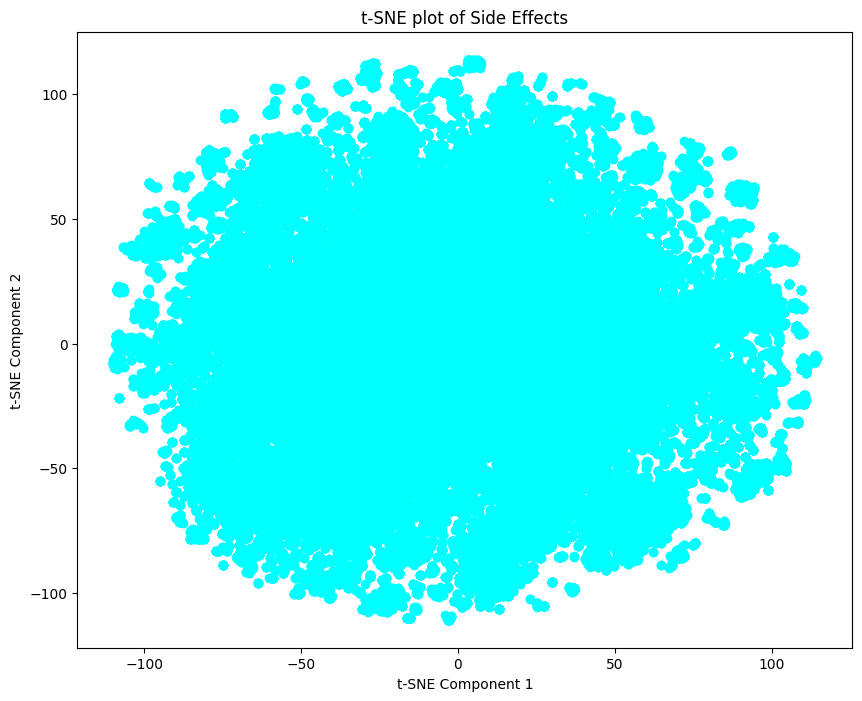

In [9]:
# plot on 2D
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, random_state=42)
X_2d = tsne.fit_transform(dense)
print('t-SNE part done!')

plt.figure(figsize=(10, 8))
plt.scatter(X_2d[:, 0], X_2d[:, 1], c='cyan')
plt.title('t-SNE plot of Side Effects')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()



DBSCAN part done!


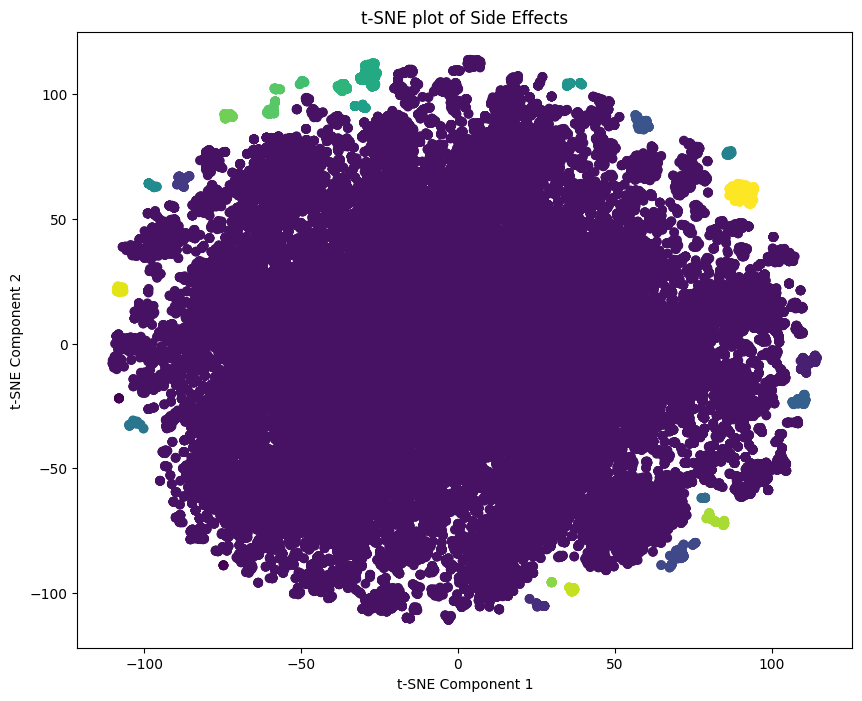

In [10]:
dbscan = DBSCAN(eps=5, min_samples=12)
clusters = dbscan.fit_predict(X_2d)
print('DBSCAN part done!')

plt.figure(figsize=(10, 8))
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=clusters, cmap='viridis')

# for i, side_effect in enumerate(side_effects[:limit]):
#     if i % 10 != 0:
#         continue
#     plt.annotate(side_effect, (X_2d[i, 0], X_2d[i, 1]), fontsize=8)

plt.title('t-SNE plot of Side Effects')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

In [ ]:
# read clusters from file
grouped_path = 'data/grouped_side_effects.txt'
# csv file, delimiter is ';-;'
grouped = pd.read_csv(grouped_path, sep=';-;', header=None)
grouped.columns = ['side_effect', 'group']
clusters = grouped['group'].values
print(clusters)

[10 16  2 ...  9 14 17]


C:\Users\Ming\AppData\Local\Temp\ipykernel_16064\2877730529.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  grouped = pd.read_csv(grouped_path, sep=';-;', header=None)


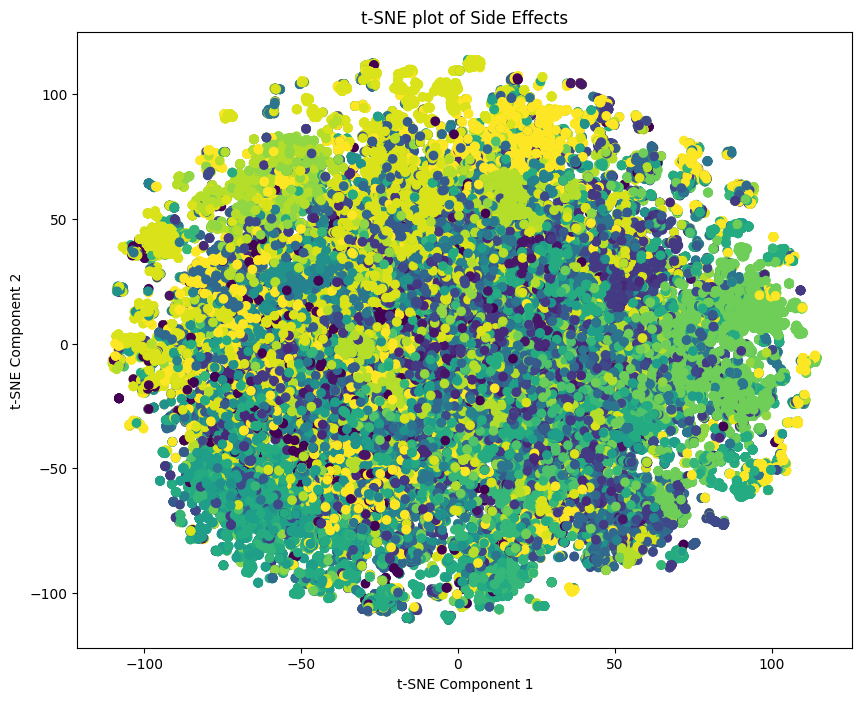

In [14]:
plt.figure(figsize=(10, 8))
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=clusters, cmap='viridis')

# for i, side_effect in enumerate(side_effects[:limit]):
#     if i % 10 != 0:
#         continue
#     plt.annotate(side_effect, (X_2d[i, 0], X_2d[i, 1]), fontsize=8)

plt.title('t-SNE plot of Side Effects')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

In [11]:
import plotly.express as px
from sklearn.manifold import TSNE
import pandas as pd

tsne = TSNE(n_components=3, random_state=42)
X_3d = tsne.fit_transform(dense)

df = pd.DataFrame(X_3d, columns=['Component 1', 'Component 2', 'Component 3'])
df['Side Effect'] = side_effects[:limit]
# interpolate with empty strings to avoid overlapping labels
for idx, row in df.iterrows():
    if idx % 20 != 0:
        df.loc[idx, 'Side Effect'] = ''
df['Cluster'] = clusters
print(df.head())

fig = px.scatter_3d(df, x='Component 1', y='Component 2', z='Component 3',
                    color='Cluster', text='Side Effect', 
                    title='3D t-SNE plot of Side Effects with DBSCAN Clusters',
                    labels={'Cluster': 'Cluster Label'})

fig.update_traces(marker=dict(size=5), textposition='top center')
fig.update_layout(autosize=True, hovermode='closest')
fig.show()


KeyboardInterrupt: 